<a href="https://colab.research.google.com/github/fabiogarcia1991/transfer_learning_cats_dogs/blob/main/transfer_learning_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
import os
import random
import shutil

In [3]:
#Download do dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/catsdogs.zip

--2023-11-29 16:36:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.207, 173.194.211.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/catsdogs.zip’

/content/catsdogs.z 100%[===================>]  65.43M   137MB/s    in 0.5s    

2023-11-29 16:36:01 (137 MB/s) - ‘/content/catsdogs.zip’ saved [68606236/68606236]



In [7]:
#descompactamento dos arquivos e criação dos diretórios

import os
import zipfile
with zipfile.ZipFile('catsdogs.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
base_dir = '/content/cats_and_dogs_filtered/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [8]:
#carregar os diretórios de treinamento e validação utilizando tensorflow.keras

training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150))
val_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(150, 150))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [9]:
#processando a função de rotação para as figuras

data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

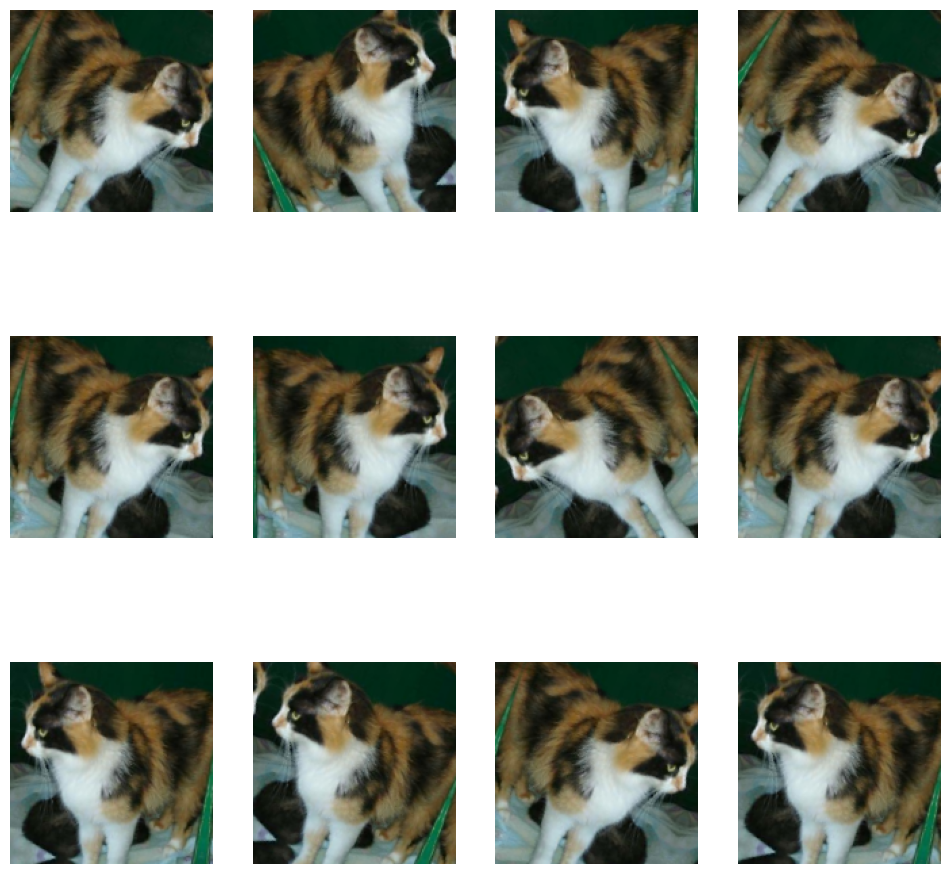

In [10]:
#Plotando algumas imagens rotacionadas

import numpy as np
import matplotlib.pyplot as plt
for images, labels in training_set.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [11]:
#criando um modelo base para treino através da rede pré-treinada Xception. A camada de topo foi excluída.

base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)

83683744/83683744 [==============================] - 1s 0us/step


In [12]:
base_model.trainable = False  #congelamento das camadas do modelo base para que não sejam atualizadas.

In [13]:
#criando as camadas densas

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)

In [14]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [16]:
#treinar o modelo por 10 épocas

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=keras.metrics.BinaryAccuracy())
model.fit(training_set, epochs=10, validation_data=val_dataset)

Epoch 1/10
63/63 [==============================] - 351s 6s/step - loss: 0.2478 - binary_accuracy: 0.8890 - val_loss: 0.0967 - val_binary_accuracy: 0.9610
Epoch 2/10
63/63 [==============================] - 343s 5s/step - loss: 0.1480 - binary_accuracy: 0.9385 - val_loss: 0.0835 - val_binary_accuracy: 0.9670
Epoch 3/10
63/63 [==============================] - 344s 6s/step - loss: 0.1247 - binary_accuracy: 0.9485 - val_loss: 0.0783 - val_binary_accuracy: 0.9730
Epoch 4/10
63/63 [==============================] - 302s 5s/step - loss: 0.1194 - binary_accuracy: 0.9495 - val_loss: 0.0743 - val_binary_accuracy: 0.9690
Epoch 5/10
63/63 [==============================] - 344s 5s/step - loss: 0.1132 - binary_accuracy: 0.9575 - val_loss: 0.0729 - val_binary_accuracy: 0.9680
Epoch 6/10
63/63 [==============================] - 345s 6s/step - loss: 0.0946 - binary_accuracy: 0.9645 - val_loss: 0.0709 - val_binary_accuracy: 0.9710
Epoch 7/10
63/63 [==============================] - 346s 6s/step - los

In [28]:
#calculando a porcentagem de acertos

_, accuracy = model.evaluate(val_dataset)
print(f"Acurácia do modelo no conjunto de validação: {accuracy * 100:.2f}%")

32/32 [==============================] - 101s 3s/step - loss: 0.0742 - binary_accuracy: 0.9680
Acurácia do modelo no conjunto de validação: 96.80%


In [48]:
#descongelamento do modelo base para treiná-lo novamente

base_model.trainable = True
fine_tune_at = 100

In [49]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
#adicionando um callback para monitorar a melhoria da acurácia e do treinamento. Caso a perda permaneça inalterada por 5 épocas seguidas, o treinamento será encerrado.

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [57]:
model.fit(training_set, epochs=10, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/10
63/63 [==============================] - 498s 8s/step - loss: 0.0740 - accuracy: 0.9685 - val_loss: 0.0631 - val_accuracy: 0.9750
Epoch 2/10
63/63 [==============================] - 484s 8s/step - loss: 0.0626 - accuracy: 0.9765 - val_loss: 0.0640 - val_accuracy: 0.9740
Epoch 3/10
63/63 [==============================] - 429s 7s/step - loss: 0.0672 - accuracy: 0.9730 - val_loss: 0.0622 - val_accuracy: 0.9730
Epoch 4/10
63/63 [==============================] - 476s 8s/step - loss: 0.0580 - accuracy: 0.9755 - val_loss: 0.0600 - val_accuracy: 0.9770
Epoch 5/10
63/63 [==============================] - 476s 8s/step - loss: 0.0488 - accuracy: 0.9825 - val_loss: 0.0631 - val_accuracy: 0.9740
Epoch 6/10
63/63 [==============================] - 474s 8s/step - loss: 0.0472 - accuracy: 0.9790 - val_loss: 0.0602 - val_accuracy: 0.9740
Epoch 7/10
63/63 [==============================] - 473s 8s/step - loss: 0.0371 - accuracy: 0.9850 - val_loss: 0.0614 - val_accuracy: 0.9740
Epoch 8/10
63

1/1 [==============================] - 2s 2s/step


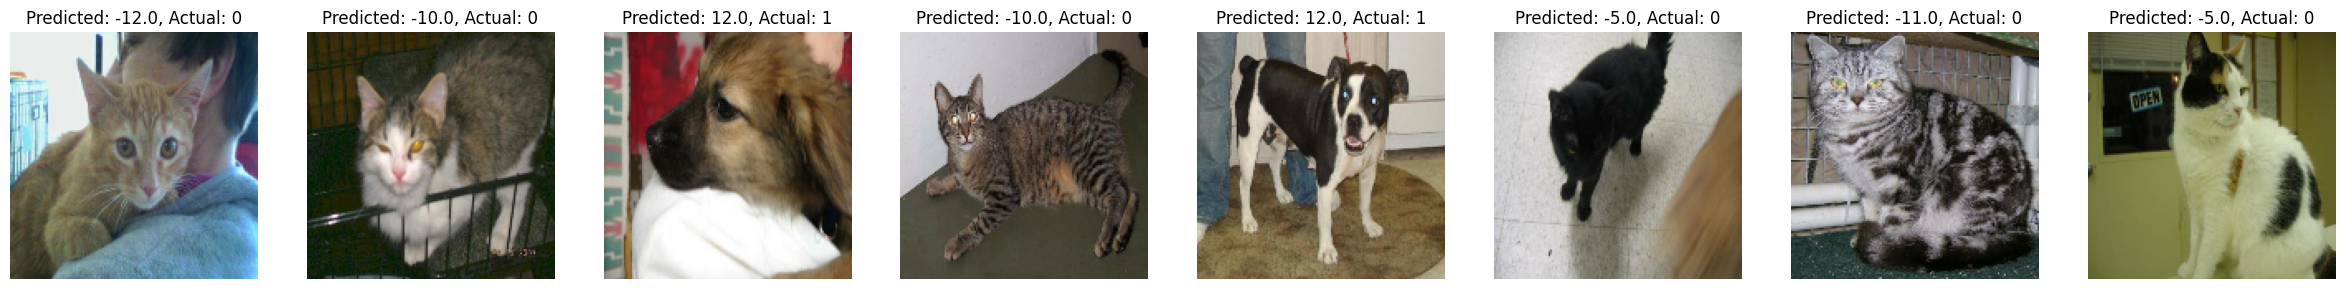

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Função para obter previsões e exibir imagens com classificação
def display_images_with_predictions(model, dataset, num_images=5):
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predicted_classes = np.round(predictions).flatten()

        # Exibir algumas imagens com suas previsões
        plt.figure(figsize=(30, 30))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Predicted: {predicted_classes[i]}, Actual: {int(labels[i])}")
            plt.axis("off")
        plt.show()

# Chame a função para exibir algumas imagens com classificação
display_images_with_predictions(model, val_dataset, num_images=8)

In [65]:
_, accuracy = model.evaluate(val_dataset)
print(f"Acurácia do modelo no conjunto de validação: {accuracy * 100:.2f}%")

32/32 [==============================] - 94s 3s/step - loss: 0.0614 - accuracy: 0.9760
Acurácia do modelo no conjunto de validação: 97.60%
